<a href="https://colab.research.google.com/github/matthew-sessions/DS-Unit-2-Kaggle-Challenge/blob/master/module2/assignment_kaggle_challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 2

## Assignment
- [X] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [X] Continue to participate in our Kaggle challenge.
- [X] Try Ordinal Encoding.
- [X] Try a Random Forest Classifier.
- [X] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_






### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module2')

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('https://raw.githubusercontent.com/matthew-sessions/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/train_features.csv'), 
                 pd.read_csv('https://raw.githubusercontent.com/matthew-sessions/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/train_labels.csv'))
test = pd.read_csv('https://raw.githubusercontent.com/matthew-sessions/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/test_features.csv')
sample_submission = pd.read_csv('https://raw.githubusercontent.com/matthew-sessions/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
import numpy as np 

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)

test = wrangle(test)
train.shape, test.shape

((59400, 46), (14358, 45))

In [0]:
train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,year_recorded,month_recorded,day_recorded,years,years_MISSING
0,6000.0,Roman,1390.0,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,...,False,False,False,False,False,2011,3,14,12.0,False
1,0.0,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,...,False,False,False,False,False,2013,3,6,3.0,False
2,25.0,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,...,False,False,False,False,False,2013,2,25,4.0,False
3,0.0,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,...,False,False,False,False,False,2013,1,28,27.0,False
4,0.0,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,...,False,False,True,True,True,2011,7,13,NaN,True


In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape


((47520, 46), (11880, 46))

In [0]:
x_train = train.drop(columns='status_group')
y_train = train['status_group']

x_val = val.drop(columns='status_group')
y_val = val['status_group']

In [0]:
x_train.shape

(47520, 45)

In [0]:
y_train.shape

(47520,)

In [0]:
num_feat = x_train.select_dtypes(include='number').columns.tolist()
card = x_train.select_dtypes(exclude='number').nunique()

cat_features = card[card <= 50].index.tolist()

In [0]:
feat = num_feat + cat_features

In [0]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline = pipeline.fit(x_train[feat],y_train)

In [0]:

print('Validation Accuracy', pipeline.score(x_val[feat], y_val))


Validation Accuracy 0.8082491582491582


In [0]:
subs = sample_submission['status_group']

In [0]:
len(subs)

14358

In [0]:

print('Validation Accuracy', pipeline.score(x_val[feat], y_val))
print('test Accuracy', pipeline.score(test[feat], subs))

Validation Accuracy 0.8082491582491582
test Accuracy 0.5793982448809026


In [0]:
encoder = pipeline.named_steps['onehotencoder']

In [0]:
encoded = encoder.transform(x_train[feat])

In [0]:
print(encoded.shape)
print(x_train[feat].shape)

(47520, 182)
(47520, 38)


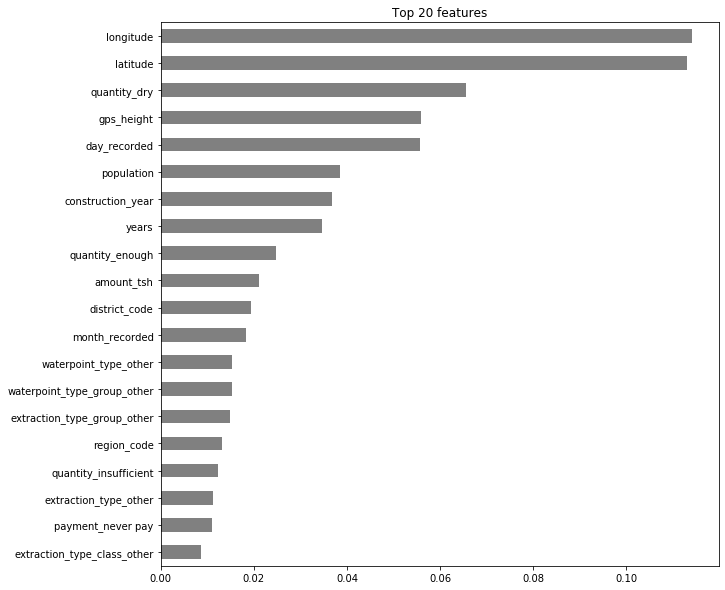

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)


n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
target = 'status_group'

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

print('test Accuracy', pipeline.score(test, subs))

Validation Accuracy 0.8085016835016835
test Accuracy 0.5927705808608441


In [0]:
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8135521885521886


In [0]:
print('test Accuracy', pipeline.score(test, subs))

test Accuracy 0.5935367042763616


In [0]:
def hotord(train,val,test,hot,ordd,nums):
    hot = hot + nums
    encoder = ce.OneHotEncoder(use_cat_names=True)
    train_tran = encoder.fit_transform(train[hot])
    val_tran = encoder.transform(val[hot])
    test_tran = encoder.transform(test[hot])
    nums2 = train_tran.columns.tolist()
    
    orden = ce.OrdinalEncoder()
    train_fin = orden.fit_transform(train[ordd])
    train_fin = pd.concat([train_fin,train_tran],axis=1)
    
    val_fin = orden.transform(val[ordd])
    val_fin = pd.concat([val_fin,val_tran],axis=1)
    
    test_fin = orden.transform(test[ordd])
    test_fin = pd.concat([test_fin,test_tran],axis=1)
    return(train_fin,val_fin,test_fin)

In [0]:
from sklearn.preprocessing import MinMaxScaler

def hotordscale(train,val,test,hot,ordd,nums):
    hot = hot + nums
    encoder = ce.OneHotEncoder(use_cat_names=True)
    train_tran = encoder.fit_transform(train[hot])
    val_tran = encoder.transform(val[hot])
    test_tran = encoder.transform(test[hot])
    nums2 = train_tran.columns.tolist()
    
    orden = ce.OrdinalEncoder()
    train_fin = orden.fit_transform(train[ordd])
    train_fin = pd.concat([train_fin,train_tran],axis=1)
    
    val_fin = orden.transform(val[ordd])
    val_fin = pd.concat([val_fin,val_tran],axis=1)
    
    test_fin = orden.transform(test[ordd])
    test_fin = pd.concat([test_fin,test_tran],axis=1)
    
    scaler = MinMaxScaler()
    train_fin = scaler.fit_transform(train_fin)
    val_fin = scaler.transform(val_fin)
    test_fin = scaler.transform(test_fin)
    
    
    return(train_fin,val_fin,test_fin)

In [0]:
cats = x_train.select_dtypes(exclude='number').nunique()

nums = train.select_dtypes(include='number').columns.tolist()

ordd = cats[card > 50].index.tolist()

hot =  cats[card < 50].index.tolist()

In [0]:
train_fin,val_fin,test_fin = hotord(train,val,test,hot,ordd,nums)

In [0]:
train_fin.shape,val_fin.shape,test_fin.shape

((47520, 189), (11880, 189), (14358, 189))

In [0]:
pipeline = make_pipeline(
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=80, random_state=42, n_jobs=-1)
)

pipeline.fit(train_fin, y_train)
print('Train Accuracy', pipeline.score(train_fin, y_train))
print('Validation Accuracy', pipeline.score(val_fin, y_val))
print('test Accuracy', pipeline.score(test_fin, subs))

Train Accuracy 0.9999579124579124
Validation Accuracy 0.8096801346801347
test Accuracy 0.5956957793564563


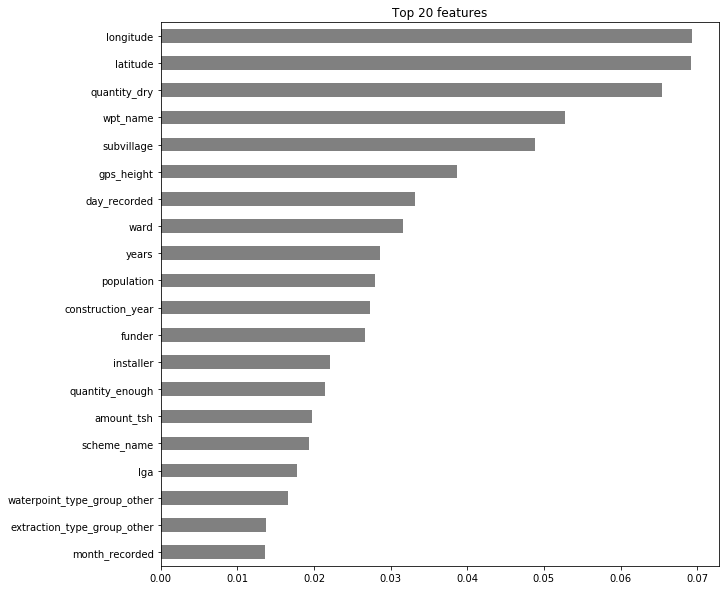

In [0]:


rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, test_fin.columns)

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
important = importances.sort_values()[-12:].index.tolist()
important

['funder',
 'construction_year',
 'population',
 'years',
 'ward',
 'day_recorded',
 'gps_height',
 'subvillage',
 'wpt_name',
 'quantity_dry',
 'latitude',
 'longitude']

In [0]:
pipeline = make_pipeline(
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
)

pipeline.fit(train_fin[important], y_train)
print('Train Accuracy', pipeline.score(train_fin[important], y_train))
print('Validation Accuracy', pipeline.score(val_fin[important], y_val))
print('test Accuracy', pipeline.score(test_fin[important], subs))

Train Accuracy 0.9994949494949495
Validation Accuracy 0.7537878787878788
test Accuracy 0.6272461345591308


In [0]:
from sklearn.tree import DecisionTreeClassifier
pipeline = make_pipeline(
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=50,random_state=42)
)

pipeline.fit(train_fin[important], y_train)
print('Train Accuracy', pipeline.score(train_fin[important], y_train))
print('Validation Accuracy', pipeline.score(val_fin[important], y_val))
print('test Accuracy', pipeline.score(test_fin[important], subs))

Train Accuracy 0.7436868686868687
Validation Accuracy 0.7202861952861953
test Accuracy 0.6411060036216744


In [0]:
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(
    SimpleImputer(),
    LogisticRegression()
)

pipeline.fit(train_fin[important], y_train)
print('Train Accuracy', pipeline.score(train_fin[important], y_train))
print('Validation Accuracy', pipeline.score(val_fin[important], y_val))
print('test Accuracy', pipeline.score(test_fin[important], subs))

C:\Users\WIN 10\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\WIN 10\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train Accuracy 0.6648989898989899
Validation Accuracy 0.6716329966329966
test Accuracy 0.7933556205599666


In [0]:
train_fin2,val_fin2,test_fin2 = hotord(train,val,test,hot,ordd,nums)

In [0]:
from sklearn.tree import DecisionTreeClassifier
pipeline = make_pipeline(
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=50,random_state=42)
)

pipeline.fit(train_fin2, y_train)
print('Train Accuracy', pipeline.score(train_fin2, y_train))
print('Validation Accuracy', pipeline.score(val_fin2, y_val))
print('test Accuracy', pipeline.score(test_fin2, subs))

Train Accuracy 0.781797138047138
Validation Accuracy 0.763973063973064
test Accuracy 0.6271068393926731


In [0]:
rf = pipeline.named_steps['decisiontreeclassifier']
importances = pd.Series(rf.feature_importances_, test_fin2.columns)

n = 20
important = importances.sort_values()[-19:].index.tolist()
important

['basin_Lake Rukwa',
 'extraction_type_other',
 'construction_year',
 'district_code',
 'population',
 'funder',
 'region_code',
 'lga',
 'ward',
 'scheme_name',
 'gps_height',
 'installer',
 'waterpoint_type_communal standpipe multiple',
 'latitude',
 'amount_tsh',
 'years',
 'longitude',
 'waterpoint_type_group_other',
 'quantity_dry']

In [0]:
pipeline = make_pipeline(
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=50,random_state=42)
)

pipeline.fit(train_fin2[important], y_train)
print('Train Accuracy', pipeline.score(train_fin2[important], y_train))
print('Validation Accuracy', pipeline.score(val_fin2[important], y_val))
print('test Accuracy', pipeline.score(test_fin2[important], subs))

Train Accuracy 0.7734638047138047
Validation Accuracy 0.7570707070707071
test Accuracy 0.6366485582950272


In [0]:
from sklearn.tree import DecisionTreeClassifier
pipeline = make_pipeline(
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=50,random_state=42)
)

pipeline.fit(train_fin2[important], y_train)
print('Train Accuracy', pipeline.score(train_fin2[important], y_train))
print('Validation Accuracy', pipeline.score(val_fin2[important], y_val))
print('test Accuracy', pipeline.score(test_fin2[important], subs))

Train Accuracy 0.7693813131313131
Validation Accuracy 0.7536195286195286
test Accuracy 0.633653712216186


In [0]:
pipeline = make_pipeline(
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
)

pipeline.fit(train_fin2, y_train)
print('Train Accuracy', pipeline.score(train_fin2, y_train))
print('Validation Accuracy', pipeline.score(val_fin2, y_val))
print('test Accuracy', pipeline.score(test_fin2, subs))

Train Accuracy 0.9953493265993266
Validation Accuracy 0.8034511784511784
test Accuracy 0.5990388633514417


In [0]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, test_fin2.columns)

n = 20
important = importances.sort_values()[-8:].index.tolist()
important

['ward',
 'day_recorded',
 'gps_height',
 'subvillage',
 'wpt_name',
 'quantity_dry',
 'longitude',
 'latitude']

In [0]:
pipeline = make_pipeline(
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
)

pipeline.fit(train_fin2[important], y_train)
print('Train Accuracy', pipeline.score(train_fin2[important], y_train))
print('Validation Accuracy', pipeline.score(val_fin2[important], y_val))
print('test Accuracy', pipeline.score(test_fin2[important], subs))

Train Accuracy 0.9999158249158249
Validation Accuracy 0.7116161616161616
test Accuracy 0.6415935367042763


In [0]:
pipeline = make_pipeline(
    SimpleImputer(),
    LogisticRegression()
)

pipeline.fit(train_fin[important], y_train)
print('Train Accuracy', pipeline.score(train_fin[important], y_train))
print('Validation Accuracy', pipeline.score(val_fin[important], y_val))
print('test Accuracy', pipeline.score(test_fin[important], subs))

C:\Users\WIN 10\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\WIN 10\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train Accuracy 0.6382575757575758
Validation Accuracy 0.647979797979798
test Accuracy 0.8816687560941635


In [0]:
y_pred = pipeline.predict(test_fin[important])

In [0]:
sample = sample_submission.copy()

In [0]:
sample.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [0]:
sample['status_group'] = y_pred

In [0]:
sample.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
sample.to_csv('submission-06.csv', index=False)